# Aktywne uczenie
Olga Krupa, Kinga Kwoka

### Środowisko wykonawcze

In [1]:
!pip install modAL-python
!pip install ucimlrepo

In [2]:
%%bash
git clone https://github.com/kzkwoka/active_learning_module.git
cd active_learning_module
git checkout dev

Cloning into 'active_learning_module'...
Already on 'dev'


M	.gitignore
M	README.md
M	experiments.ipynb
D	experiments_covertype.ipynb
M	requirements.txt
M	src/utils.py
Your branch is up to date with 'origin/dev'.


In [8]:
!git checkout dev

Branch 'dev' set up to track remote branch 'dev' from 'origin'.

Switched to a new branch 'dev'


In [3]:
%cd active_learning_module

c:\Users\kolga\Desktop\zum\active_learning_module\active_learning_module


In [11]:
pwd

'c:\\Users\\kolga\\Desktop\\zum\\active_learning_module\\active_learning_module'

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
from ucimlrepo import fetch_ucirepo

import matplotlib.pyplot as plt
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix

from src.active import ActiveModule
from src.strategies import *
from src.utils import *

## Cover Type

### Zbiór danych

In [15]:
# fetch dataset
dataset = fetch_ucirepo(id=186) # id=31 (covertype), 144(), 186 (wine quality)

# data (as pandas dataframes)
X = dataset.data.features
y = dataset.data.targets

if dataset.metadata.uci_id == 31:
    _, X, _, y = train_test_split(X, y, test_size=0.1, random_state=42)

n_classes = y.nunique().iloc[0]

### Wstępne przetwarzanie

In [16]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

### Losowy zbiór początkowy

In [18]:
np.random.seed(42)
initial_idx = np.random.randint(low=0, high=X_train.shape[0], size=int(0.1*X_train.shape[0]))

### Ocena na całym zbiorze danych

In [39]:
t = KNeighborsClassifier(n_neighbors=n_classes)
t.fit(X_train, y_train)
y_pred = t.predict(X_test)

In [40]:
lbin = LabelBinarizer().fit(y_train)
matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
benchmark = {
    'default_metric': t.score(X_test, y_test),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro'),
    'roc_auc': roc_auc_score(matrix, matrix_pred),
    'pr_auc': average_precision_score(matrix, matrix_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

In [41]:
{key: round(value,3) for key, value in benchmark.items() if key in ('accuracy', 'roc_auc', 'pr_auc')}

{'accuracy': 0.568, 'roc_auc': 0.582, 'pr_auc': 0.206}

### Aktywne uczenie

In [42]:
learner = ActiveModule(estimator=KNeighborsClassifier,
                       X=X_train,
                       y_initial=y_train.values[initial_idx],
                       label_idx=initial_idx,
                       X_valid=X_test,
                       y_valid=y_test.values,
                       n_neighbors=n_classes,)

In [43]:
n_samples = 100
n_iter = math.ceil((X_train.shape[0] - initial_idx.shape[0])/n_samples)

In [47]:
metrics, info = run_experiments(learner, y_train, [random_sampling, uncertainty_sampling, kmeans_plus_plus_sampling,], n_samples, n_iter)  #14 min  diversity_sampling

100%|██████████| 4/4 [15:16<00:00, 229.03s/it]


In [48]:
for i in info:
    print(i)

One training loop with random_sampling takes approx. 0.3s
One training loop with uncertainty_sampling takes approx. 0.43s
One training loop with kmeans_plus_plus_sampling takes approx. 0.34s
One training loop with diversity_sampling takes approx. 18.42s


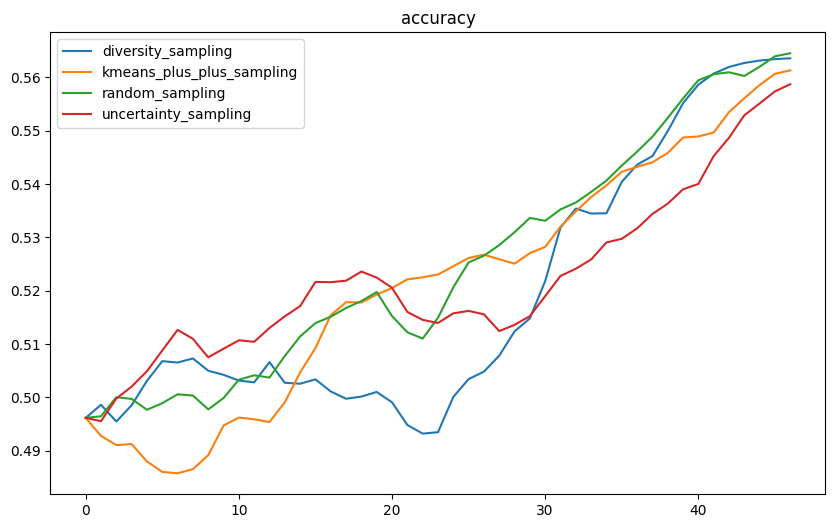

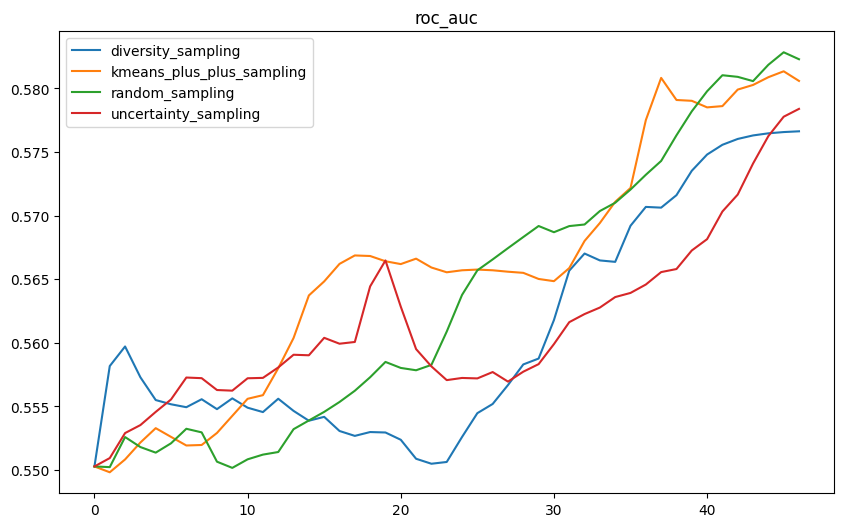

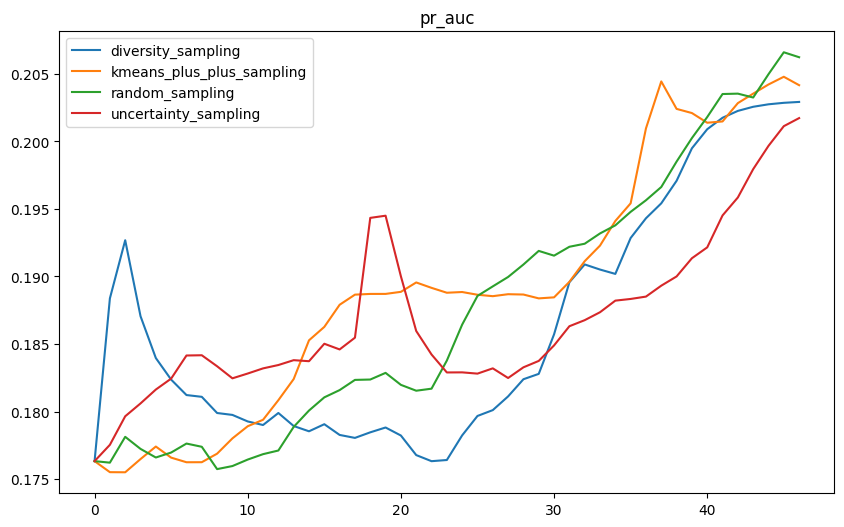

In [49]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.6), label=f'{strategy}')
    plt.legend()
    plt.title(metric)
    plt.show()

### Aktywne uczenie z biblioteką modAL

In [50]:
import modAL
from modAL.models import ActiveLearner

In [57]:
mlearner = ActiveLearner(
    estimator=KNeighborsClassifier(n_neighbors=n_classes),
    query_strategy=modAL.uncertainty.uncertainty_sampling,
    X_training=X_train[initial_idx], y_training=y_train.values[initial_idx]
)
X_to_train = X_train.copy()
y_to_train = y_train.values.copy()
modAL_metrics = []

query_idx = initial_idx

for i in (t:= tqdm(range(n_iter))):
    mlearner.teach(X_to_train[query_idx], y_to_train[query_idx])
    
    X_to_train = np.delete(X_to_train, query_idx, axis=0)
    y_to_train = np.delete(y_to_train, query_idx, axis=0)
    y_pred = mlearner.predict(X_test)
    matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
    modAL_metrics.append({
        'default_metric': mlearner.score(X_test, y_test),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1': f1_score(y_test, y_pred, average='macro'),
        'roc_auc': roc_auc_score(matrix, matrix_pred),
        'pr_auc': average_precision_score(matrix, matrix_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    })
    query_idx, query_inst = mlearner.query(X_to_train, n_instances=n_samples)

avg_loop_time = t.format_dict['elapsed']/ t.format_dict['total']  
modAL_metrics = pd.DataFrame(modAL_metrics)
# modAL_metrics[["accuracy", "pr_auc", "roc_auc"]].plot()
# print(learner.score(X_test, y_test))

100%|██████████| 47/47 [00:19<00:00,  2.41it/s]


In [58]:
f"One training loop with uncertainty_sampling from modAL takes approx. {round(avg_loop_time, 2)}s"

'One training loop with uncertainty_sampling from modAL takes approx. 0.41s'

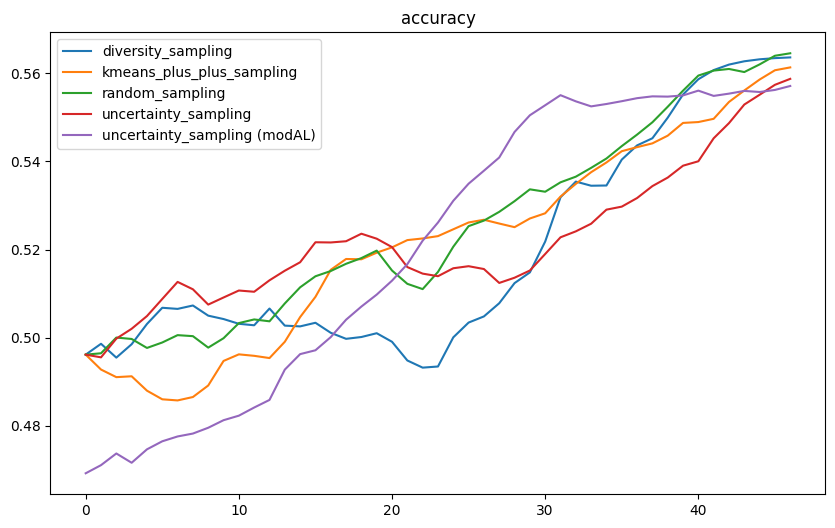

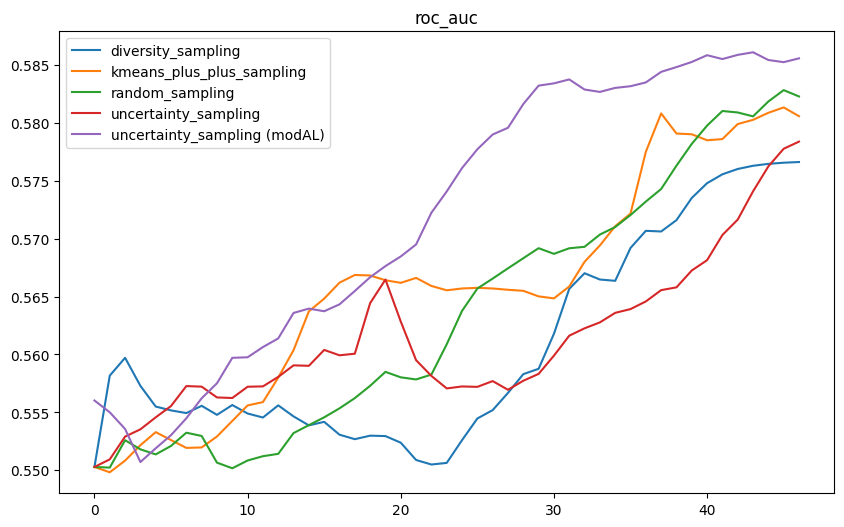

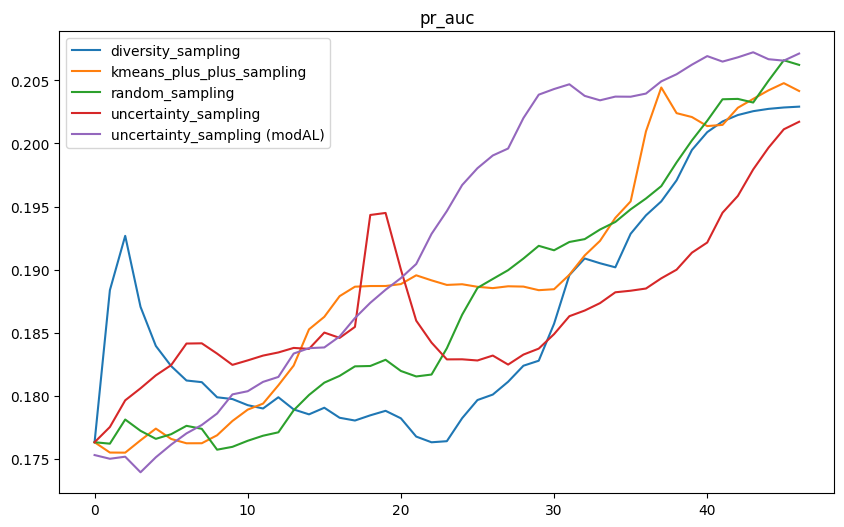

In [59]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.6), label=f'{strategy}')
    ax.plot(modAL_metrics.index, smooth(modAL_metrics[metric], 0.6), label=f'uncertainty_sampling (modAL)')
    plt.legend()
    plt.title(metric)
    plt.show()

In [63]:
metrics

default_metric  accuracy  precision    recall  \
strategy                                                               
random_sampling    0         0.496154  0.496154   0.496154  0.496154   
                   1         0.496923  0.496923   0.496923  0.496923   
                   2         0.505385  0.505385   0.505385  0.505385   
                   3         0.499231  0.499231   0.499231  0.499231   
                   4         0.494615  0.494615   0.494615  0.494615   
...                               ...       ...        ...       ...   
diversity_sampling 42        0.563846  0.563846   0.563846  0.563846   
                   43        0.563846  0.563846   0.563846  0.563846   
                   44        0.563846  0.563846   0.563846  0.563846   
                   45        0.563846  0.563846   0.563846  0.563846   
                   46        0.563846  0.563846   0.563846  0.563846   

                             f1   roc_auc    pr_auc  \
strategy                                              
random_sampling    0   0.496154  0.550279  0.176335   
                   1   0.496923  0.550149  0.176053   
                   2   0.505385  0.556134  0.180999   
                   3   0.499231  0.550625  0.175902   
                   4   0.494615  0.550706  0.175649   
...                         ...       ...       ...   
diversity_sampling 42  0.563846  0.576713  0.203006   
                   43  0.563846  0.576713  0.203006   
                   44  0.563846  0.576713  0.203006   
                   45  0.563846  0.576713  0.203006   
                   46  0.563846  0.576713  0.203006   

                                                        confusion_matrix  
strategy                                                                  
random_sampling    0   [[0, 1, 3, 2, 0, 0, 0], [0, 1, 21, 20, 1, 0, 0...  
                   1   [[0, 0, 4, 2, 0, 0, 0], [0, 2, 25, 15, 1, 0, 0...  
                   2   [[0, 0, 2, 3, 1, 0, 0], [0, 3, 27, 13, 0, 0, 0...  
                   3   [[0, 0, 2, 3, 1, 0, 0], [0, 3, 27, 13, 0, 0, 0...  
                   4   [[0, 0, 3, 3, 0, 0, 0], [0, 3, 27, 13, 0, 0, 0...  
...                                                                  ...  
diversity_sampling 42  [[0, 0, 3, 2, 1, 0, 0], [1, 2, 22, 17, 1, 0, 0...  
                   43  [[0, 0, 3, 2, 1, 0, 0], [1, 2, 22, 17, 1, 0, 0...  
                   44  [[0, 0, 3, 2, 1, 0, 0], [1, 2, 22, 17, 1, 0, 0...  
                   45  [[0, 0, 3, 2, 1, 0, 0], [1, 2, 22, 17, 1, 0, 0...  
                   46  [[0, 0, 3, 2, 1, 0, 0], [1, 2, 22, 17, 1, 0, 0...  

[188 rows x 8 columns]